In [1]:
!git clone https://github.com/sheikhtajamul38/Adversarial-Collaborative-Filtering---RecSys.git

Cloning into 'Adversarial-Collaborative-Filtering---RecSys'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 75 (delta 16), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (75/75), 17.52 MiB | 4.78 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [17]:
dataset = 'ml-1m'

main_path = '/kaggle/working/Adversarial-Collaborative-Filtering---RecSys/Data/'

train_rating = main_path + '{}.train.rating'.format(dataset)
test_rating = main_path + '{}.test.rating'.format(dataset)
test_negative = main_path + '{}.test.negative'.format(dataset)

model_path = './models/'
BPR_model_path = model_path + 'BPR.pth'

In [18]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import torch.utils.data as data


def load_all(test_num=100):
	""" We load all the three file here to save time in each epoch. """
	train_data = pd.read_csv(
		train_rating,
		sep='\t', header=None, names=['user', 'item'],
		usecols=[0, 1], dtype={0: np.int32, 1: np.int32})

	user_num = train_data['user'].max() + 1
	item_num = train_data['item'].max() + 1

	train_data = train_data.values.tolist()

	# load ratings as a dok matrix
	train_mat = sp.dok_matrix((user_num, item_num), dtype=np.float32)
	for x in train_data:
		train_mat[x[0], x[1]] = 1.0

	test_data = []
	with open(test_negative, 'r') as fd:
		line = fd.readline()
		while line != None and line != '':
			arr = line.split('\t')
			u = eval(arr[0])[0]
			test_data.append([u, eval(arr[0])[1]])
			for i in arr[1:]:
				test_data.append([u, int(i)])
			line = fd.readline()
	return train_data, test_data, user_num, item_num, train_mat


class BPRData(data.Dataset):
	def __init__(self, features,
				num_item, train_mat=None, num_ng=0, is_training=None):
		super(BPRData, self).__init__()
		""" Note that the labels are only useful when training, we thus
			add them in the ng_sample() function.
		"""
		self.features = features
		self.num_item = num_item
		self.train_mat = train_mat
		self.num_ng = num_ng
		self.is_training = is_training

	def ng_sample(self):
		assert self.is_training, 'no need to sampling when testing'

		self.features_fill = []
		for x in self.features:
			u, i = x[0], x[1]
			for t in range(self.num_ng):
				j = np.random.randint(self.num_item)
				while (u, j) in self.train_mat:
					j = np.random.randint(self.num_item)
				self.features_fill.append([u, i, j])

	def __len__(self):
		return self.num_ng * len(self.features) if \
				self.is_training else len(self.features)

	def __getitem__(self, idx):
		features = self.features_fill if \
				self.is_training else self.features

		user = features[idx][0]
		item_i = features[idx][1]
		item_j = features[idx][2] if \
				self.is_training else features[idx][1]
		return user, item_i, item_j


In [19]:
class BPRData(data.Dataset):
    def __init__(self, features, num_item, train_mat=None, num_ng=0, is_training=None):
        super(BPRData, self).__init__()
        self.features = features
        self.num_item = num_item
        self.train_mat = train_mat
        self.num_ng = num_ng
        self.is_training = is_training

        # Initialize features_fill
        self.features_fill = []

    def ng_sample(self):
        assert self.is_training, 'no need to sampling when testing'

        self.features_fill = []
        for x in self.features:
            u, i = x[0], x[1]
            for t in range(self.num_ng):
                j = np.random.randint(self.num_item)
                while (u, j) in self.train_mat:
                    j = np.random.randint(self.num_item)
                self.features_fill.append([u, i, j])

    def __len__(self):
        return self.num_ng * len(self.features) if self.is_training else len(self.features)

    def __getitem__(self, idx):
        features = self.features_fill if self.is_training else self.features
        user = features[idx][0]
        item_i = features[idx][1]
        item_j = features[idx][2] if self.is_training else features[idx][1]
        return idx, user, item_i, item_j


In [20]:
import numpy as np
import torch

def hit(gt_item, pred_items):
    if gt_item in pred_items:
        return 1
    return 0

def ndcg(gt_item, pred_items):
    if gt_item in pred_items:
        index = pred_items.index(gt_item)
        return np.reciprocal(np.log2(index+2))
    return 0

def metrics(model, test_loader, top_k, device):
    HR, NDCG = [], []

    for _, user, item_i, item_j in test_loader:
        user = user.to(device)
        item_i = item_i.to(device)
        item_j = item_j.to(device)  # not useful when testing

        prediction_i, prediction_j = model(user, item_i, item_j)
        _, indices = torch.topk(prediction_i, top_k)
        recommends = torch.take(item_i, indices).cpu().numpy().tolist()

        gt_item = item_i[0].item()
        HR.append(hit(gt_item, recommends))
        NDCG.append(ndcg(gt_item, recommends))

    return np.mean(HR), np.mean(NDCG)


In [21]:
import torch
import torch.nn as nn


class BPR(nn.Module):
	def __init__(self, user_num, item_num, factor_num):
		super(BPR, self).__init__()
		"""
		user_num: number of users;
		item_num: number of items;
		factor_num: number of predictive factors.
		"""
		self.embed_user = nn.Embedding(user_num, factor_num)
		self.embed_item = nn.Embedding(item_num, factor_num)

		nn.init.normal_(self.embed_user.weight, std=0.01)
		nn.init.normal_(self.embed_item.weight, std=0.01)

	def forward(self, user, item_i, item_j):
		user = self.embed_user(user)
		item_i = self.embed_item(item_i)
		item_j = self.embed_item(item_j)

		prediction_i = (user * item_i).sum(dim=-1)
		prediction_j = (user * item_j).sum(dim=-1)
		return prediction_i, prediction_j

In [22]:
import os
import time
import argparse
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.backends.cudnn as cudnn


def set_args():
    args = argparse.Namespace()
    args.lr = 0.01
    args.lamda = 0.001
    args.batch_size = 4096
    args.epochs = 200
    args.top_k = 10
    args.factor_num = 128
    args.num_ng = 1
    args.test_num_ng = 99
    args.out = False

    return args

args = set_args()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [23]:
############################## PREPARE DATASET ##########################
train_data, test_data, user_num ,item_num, train_mat = load_all()

# construct the train and test datasets
train_dataset = BPRData(train_data, item_num, train_mat, args.num_ng, True)
test_dataset = BPRData(test_data, item_num, train_mat, 0, False)
train_loader = data.DataLoader(train_dataset,batch_size=args.batch_size, shuffle=True, num_workers=2)
test_loader = data.DataLoader(test_dataset,batch_size=args.test_num_ng+1, shuffle=False, num_workers=0)


In [24]:
########################### CREATE MODEL #################################
model = BPR(user_num, item_num, args.factor_num).to(device)

optimizer = optim.SGD(
			model.parameters(), lr=args.lr, weight_decay=args.lamda)
########################### TRAINING #####################################
count, best_recall = 0, 0
bpr_recall_history = []
bpr_ndcg_history = []

for epoch in range(args.epochs):
    model.train()
    start_time = time.time()
    train_loader.dataset.ng_sample()

    for batch_data in train_loader:
        batch_index, user, item_i, item_j = batch_data
        user = user.to(device)
        item_i = item_i.to(device)
        item_j = item_j.to(device)

        model.zero_grad()
        prediction_i, prediction_j = model(user, item_i, item_j)
        loss = - (prediction_i - prediction_j).sigmoid().log().sum() #BPR Loss
        loss.backward()
        optimizer.step()
        count += 1

    model.eval()
    Recall, NDCG = metrics(model, test_loader, args.top_k, device)

    bpr_recall_history.append(Recall)
    bpr_ndcg_history.append(NDCG)


    elapsed_time = time.time() - start_time
    print("The time elapse of epoch {:03d}".format(epoch) + " is: " +
        time.strftime("%H: %M: %S", time.gmtime(elapsed_time)))
    print("Recall: {:.3f}\tNDCG: {:.3f}".format(np.mean(Recall), np.mean(NDCG)))

    if Recall > best_recall:
      best_recall, best_ndcg, best_epoch = Recall, NDCG, epoch
      if args.out:
        if not os.path.exists(model_path):
          os.mkdir(model_path)
        torch.save(model, '{}BPR.pt'.format(model_path))

print("End. Best epoch {:03d}: Recall = {:.3f}, \
	NDCG = {:.3f}".format(best_epoch, best_recall, best_ndcg))

The time elapse of epoch 000 is: 00: 00: 16
Recall: 0.127	NDCG: 0.059
The time elapse of epoch 001 is: 00: 00: 16
Recall: 0.414	NDCG: 0.227
The time elapse of epoch 002 is: 00: 00: 17
Recall: 0.440	NDCG: 0.244
The time elapse of epoch 003 is: 00: 00: 16
Recall: 0.443	NDCG: 0.246
The time elapse of epoch 004 is: 00: 00: 16
Recall: 0.448	NDCG: 0.250
The time elapse of epoch 005 is: 00: 00: 16
Recall: 0.449	NDCG: 0.250
The time elapse of epoch 006 is: 00: 00: 17
Recall: 0.457	NDCG: 0.255
The time elapse of epoch 007 is: 00: 00: 16
Recall: 0.463	NDCG: 0.259
The time elapse of epoch 008 is: 00: 00: 16
Recall: 0.471	NDCG: 0.263
The time elapse of epoch 009 is: 00: 00: 16
Recall: 0.485	NDCG: 0.271
The time elapse of epoch 010 is: 00: 00: 16
Recall: 0.490	NDCG: 0.275
The time elapse of epoch 011 is: 00: 00: 16
Recall: 0.500	NDCG: 0.281
The time elapse of epoch 012 is: 00: 00: 16
Recall: 0.512	NDCG: 0.288
The time elapse of epoch 013 is: 00: 00: 16
Recall: 0.521	NDCG: 0.292
The time elapse of e

In [28]:
# Additional parameters for SharpCF
lambda_reg = 1  # Regularization parameter
E = 3  # Epoch window for trajectory loss
E_start = 50  # Start epoch for trajectory loss

In [29]:
class SharpCFLoss(nn.Module):
    def __init__(self):
        super(SharpCFLoss, self).__init__()
        self.previous_scores = {}

    def forward(self, model, batch_index, user, item_i, item_j, epoch):
        prediction_i, prediction_j = model(user, item_i, item_j)
        bpr_loss = - (prediction_i - prediction_j).sigmoid().log().sum()

        # Calculate trajectory loss if applicable
        trajectory_loss = 0
        if epoch >= E_start:
            prev_key = (epoch - E, batch_index)
            if prev_key in self.previous_scores:
                prev_scores = self.previous_scores[prev_key]
                trajectory_loss = lambda_reg / len(user) * ((prediction_i - prev_scores) ** 2).sum()

        # Cache current scores for future trajectory loss calculation
        self.previous_scores[(epoch, batch_index)] = prediction_i.detach()

        return bpr_loss + trajectory_loss


In [30]:
########################### CREATE MODEL #################################
model = BPR(user_num, item_num, args.factor_num).to(device)
sharp_cf_loss = SharpCFLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, weight_decay=args.lamda)

########################### TRAINING #####################################
count, best_recall = 0, 0
SCF_recall_history = []
SCF_ndcg_history = []
# Training loop
for epoch in range(args.epochs):
    model.train()
    start_time = time.time()
    train_loader.dataset.ng_sample()

    for batch_data in train_loader:
        batch_index, user, item_i, item_j = batch_data
        batch_index = batch_index.to(device)
        user = user.to(device)
        item_i = item_i.to(device)
        item_j = item_j.to(device)
        model.zero_grad()

        # Calculate SharpCF loss
        loss = sharp_cf_loss(model, batch_index, user, item_i, item_j, epoch)
        loss.backward()
        optimizer.step()
    print('loss',loss)
    model.eval()
    Recall, NDCG = metrics(model, test_loader, args.top_k, device)

    SCF_recall_history.append(Recall)
    SCF_ndcg_history.append(NDCG)


    elapsed_time = time.time() - start_time
    print("The time elapse of epoch {:03d}".format(epoch) + " is: " +
        time.strftime("%H: %M: %S", time.gmtime(elapsed_time)))
    print("Recall: {:.3f}\tNDCG: {:.3f}".format(np.mean(Recall), np.mean(NDCG)))

    if Recall > best_recall:
      best_recall, best_ndcg, best_epoch = Recall, NDCG, epoch
      if args.out:
        if not os.path.exists(model_path):
          os.mkdir(model_path)
        torch.save(model, '{}BPR.pt'.format(model_path))

print("End. Best epoch {:03d}: Recall = {:.3f}, \
	NDCG = {:.3f}".format(best_epoch, best_recall, best_ndcg))

loss tensor(2035.4126, device='cuda:0', grad_fn=<AddBackward0>)
The time elapse of epoch 000 is: 00: 00: 15
Recall: 0.123	NDCG: 0.058
loss tensor(1998.1442, device='cuda:0', grad_fn=<AddBackward0>)
The time elapse of epoch 001 is: 00: 00: 16
Recall: 0.400	NDCG: 0.221
loss tensor(1395.0845, device='cuda:0', grad_fn=<AddBackward0>)
The time elapse of epoch 002 is: 00: 00: 16
Recall: 0.442	NDCG: 0.245
loss tensor(1118.0101, device='cuda:0', grad_fn=<AddBackward0>)
The time elapse of epoch 003 is: 00: 00: 16
Recall: 0.447	NDCG: 0.249
loss tensor(1033.0305, device='cuda:0', grad_fn=<AddBackward0>)
The time elapse of epoch 004 is: 00: 00: 16
Recall: 0.446	NDCG: 0.248
loss tensor(964.1699, device='cuda:0', grad_fn=<AddBackward0>)
The time elapse of epoch 005 is: 00: 00: 16
Recall: 0.448	NDCG: 0.250


KeyboardInterrupt: 

In [31]:
import matplotlib.pyplot as plt

In [33]:
model = BPR(user_num, item_num, args.factor_num).to(device)
sharp_cf_loss = SharpCFLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, weight_decay=args.lamda)
count, best_recall = 0, 0

# Initialize lists to store recall and NDCG values
SCF_recall_history = []
SCF_ndcg_history = []

# Create a figure for plotting
plt.figure(figsize=(12, 6))

for epoch in range(100):
    model.train()
    start_time = time.time()
    train_loader.dataset.ng_sample()

    for batch_data in train_loader:
        batch_index, user, item_i, item_j = batch_data
        batch_index = batch_index.to(device)
        user = user.to(device)
        item_i = item_i.to(device)
        item_j = item_j.to(device)
        model.zero_grad()

        # Calculate SharpCF loss
        loss = sharp_cf_loss(model, batch_index, user, item_i, item_j, epoch)
        loss.backward()
        optimizer.step()

    model.eval()
    Recall, NDCG = metrics(model, test_loader, args.top_k, device)

    SCF_recall_history.append(np.mean(Recall))
    SCF_ndcg_history.append(np.mean(NDCG))

    elapsed_time = time.time() - start_time
    print("The time elapse of epoch {:03d}".format(epoch) + " is: " +
        time.strftime("%H: %M: %S", time.gmtime(elapsed_time)))
    print("Recall: {:.3f}\tNDCG: {:.3f}".format(np.mean(Recall), np.mean(NDCG)))

    if Recall > best_recall:
        best_recall, best_ndcg, best_epoch = Recall, NDCG, epoch
        if args.out:
            if not os.path.exists(model_path):
                os.mkdir(model_path)
            torch.save(model, '{}BPR.pt'.format(model_path))

%matplotlib inline

print("End. Best epoch {:03d}: Recall = {:.3f}, \
    NDCG = {:.3f}".format(best_epoch, best_recall, best_ndcg))

The time elapse of epoch 000 is: 00: 00: 15
Recall: 0.123	NDCG: 0.058
The time elapse of epoch 001 is: 00: 00: 16
Recall: 0.409	NDCG: 0.224
The time elapse of epoch 002 is: 00: 00: 15
Recall: 0.440	NDCG: 0.245
The time elapse of epoch 003 is: 00: 00: 16
Recall: 0.443	NDCG: 0.248
The time elapse of epoch 004 is: 00: 00: 16
Recall: 0.449	NDCG: 0.250
The time elapse of epoch 005 is: 00: 00: 15
Recall: 0.453	NDCG: 0.252
The time elapse of epoch 006 is: 00: 00: 15
Recall: 0.455	NDCG: 0.254
The time elapse of epoch 007 is: 00: 00: 16
Recall: 0.461	NDCG: 0.257
The time elapse of epoch 008 is: 00: 00: 15
Recall: 0.468	NDCG: 0.261
The time elapse of epoch 009 is: 00: 00: 15
Recall: 0.477	NDCG: 0.267
The time elapse of epoch 010 is: 00: 00: 16
Recall: 0.487	NDCG: 0.273
The time elapse of epoch 011 is: 00: 00: 15
Recall: 0.502	NDCG: 0.280
The time elapse of epoch 012 is: 00: 00: 16
Recall: 0.509	NDCG: 0.285
The time elapse of epoch 013 is: 00: 00: 15
Recall: 0.519	NDCG: 0.291
The time elapse of e

<Figure size 1200x600 with 0 Axes>

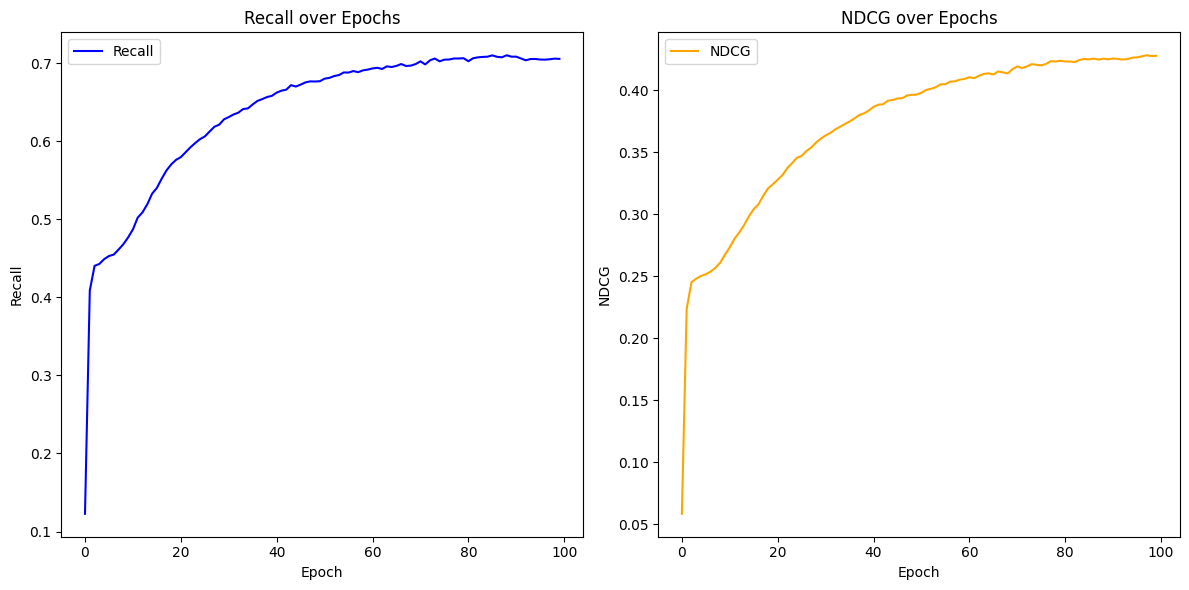

In [34]:
import matplotlib.pyplot as plt

# Assume SCF_recall_history and SCF_ndcg_history are populated with the actual values from the training loop

# Plotting both recall and NDCG on separate subplots
plt.figure(figsize=(12, 6))

# Subplot for Recall
plt.subplot(1, 2, 1)
plt.plot(SCF_recall_history, label='Recall', color='blue')
plt.title('Recall over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# Subplot for NDCG
plt.subplot(1, 2, 2)
plt.plot(SCF_ndcg_history, label='NDCG', color='orange')
plt.title('NDCG over Epochs')
plt.xlabel('Epoch')
plt.ylabel('NDCG')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


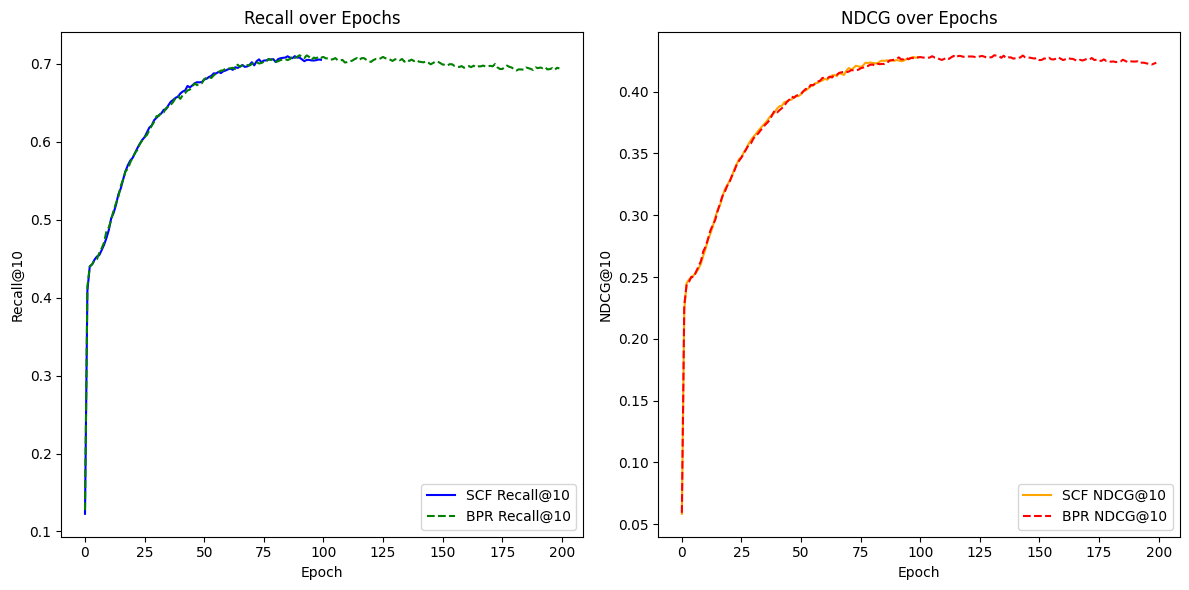

In [37]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))

# Subplot for Recall
plt.subplot(1, 2, 1)
plt.plot(SCF_recall_history, label='SCF Recall@10', color='blue')
plt.plot(bpr_recall_history, label='BPR Recall@10', color='green', linestyle='--')
plt.title('Recall over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall@10')
plt.legend()

# Subplot for NDCG
plt.subplot(1, 2, 2)
plt.plot(SCF_ndcg_history, label='SCF NDCG@10', color='orange')
plt.plot(bpr_ndcg_history, label='BPR NDCG@10', color='red', linestyle='--')
plt.title('NDCG over Epochs')
plt.xlabel('Epoch')
plt.ylabel('NDCG@10')
plt.legend()

plt.tight_layout()
plt.show()
